Epoch 0: Train Loss=4.7267, Test Loss=4.7278, Train Acc=0.0120, Test Acc=0.0071
Epoch 200: Train Loss=3.4191, Test Loss=6.7921, Train Acc=0.1350, Test Acc=0.0003
Epoch 400: Train Loss=1.5883, Test Loss=10.5961, Train Acc=0.6294, Test Acc=0.0001
Epoch 600: Train Loss=0.4264, Test Loss=14.0627, Train Acc=0.9324, Test Acc=0.0004
Epoch 800: Train Loss=0.0996, Test Loss=16.0324, Train Acc=0.9351, Test Acc=0.0014
Epoch 1000: Train Loss=0.0277, Test Loss=17.1900, Train Acc=0.9351, Test Acc=0.0023
Epoch 1200: Train Loss=0.0083, Test Loss=18.1614, Train Acc=0.9351, Test Acc=0.0031
Epoch 1400: Train Loss=0.0026, Test Loss=19.0137, Train Acc=0.9351, Test Acc=0.0034
Epoch 1600: Train Loss=0.0009, Test Loss=19.8081, Train Acc=0.9351, Test Acc=0.0040
Epoch 1800: Train Loss=0.0003, Test Loss=20.5393, Train Acc=0.9351, Test Acc=0.0056
Epoch 2000: Train Loss=0.0001, Test Loss=21.1794, Train Acc=0.9351, Test Acc=0.0064
Epoch 2200: Train Loss=0.0001, Test Loss=21.6133, Train Acc=0.9351, Test Acc=0.0071
E

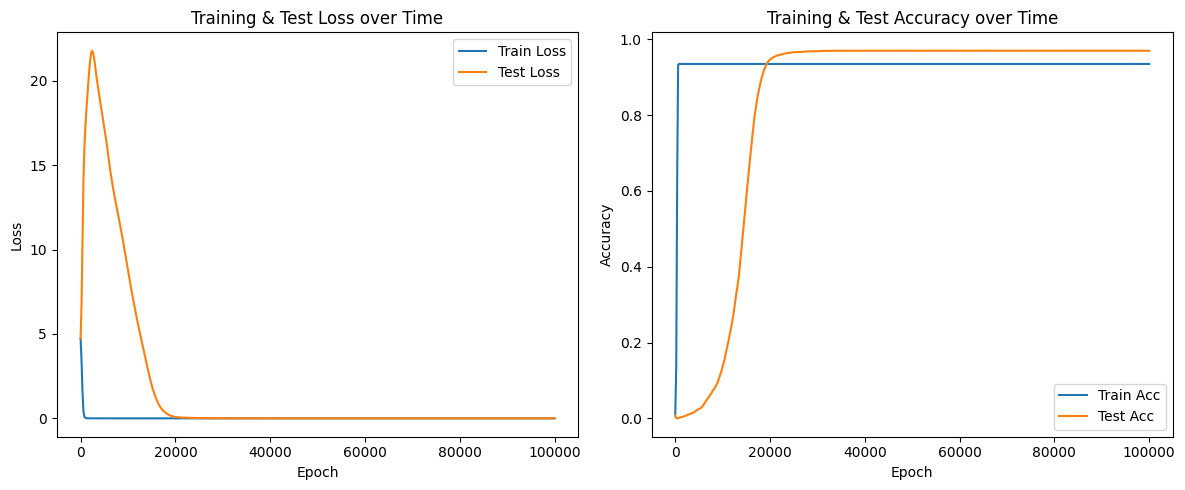

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

torch.manual_seed(42)
np.random.seed(42)


N = 113
fraction_train = 0.3  
lr = 1e-3
weight_decay = 1.0
betas = (0.9, 0.98)
epochs = 100000
checkpoint_interval = 200


os.makedirs("checkpoints_lstm_report", exist_ok=True)


all_pairs = [(x, y) for x in range(N) for y in range(N)]
np.random.shuffle(all_pairs)
all_pairs = np.array(all_pairs)

total_size = len(all_pairs)
train_size = int(total_size * fraction_train)
test_size = total_size - train_size

train_pairs = all_pairs[:train_size]
test_pairs = all_pairs[train_size:]

def pairs_to_dataset(pairs):
    xs = torch.tensor(pairs[:, 0], dtype=torch.long)
    ys = torch.tensor(pairs[:, 1], dtype=torch.long)
    targets = (xs + ys) % N
    return xs, ys, targets

train_x, train_y, train_t = pairs_to_dataset(train_pairs)
test_x, test_y, test_t = pairs_to_dataset(test_pairs)
train_seq = torch.stack([train_x, train_y], dim=1) 
train_targets = train_t
test_seq = torch.stack([test_x, test_y], dim=1)   
test_targets = test_t

class CustomLSTMModelOneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super(CustomLSTMModelOneHot, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

       
        self.W_ih = nn.Linear(vocab_size, 4*hidden_size, bias=True)
        self.W_hh = nn.Linear(hidden_size, 4*hidden_size, bias=True)

        
        self.fc1 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc2 = nn.Linear(hidden_size, vocab_size, bias=False)

        self.relu = nn.ReLU()

    def forward(self, x_seq):
        
        batch_size, seq_len = x_seq.size()
        device = x_seq.device

        
        x_onehot = torch.zeros(batch_size, seq_len, self.vocab_size, device=device)
        x_onehot.scatter_(2, x_seq.unsqueeze(2), 1)

       
        h = torch.zeros(batch_size, self.hidden_size, device=device)
        c = torch.zeros(batch_size, self.hidden_size, device=device)

       
        for t in range(seq_len):
            x_t = x_onehot[:, t, :]  

            
            gates = self.W_ih(x_t) + self.W_hh(h)
            i = torch.sigmoid(gates[:, 0:self.hidden_size])
            f = torch.sigmoid(gates[:, self.hidden_size:2*self.hidden_size])
            g = torch.tanh(gates[:, 2*self.hidden_size:3*self.hidden_size])
            o = torch.sigmoid(gates[:, 3*self.hidden_size:4*self.hidden_size])

            c = f * c + i * g
            
            h = self.relu(c)

       
        intermediate = self.fc1(h)
        logits = self.fc2(intermediate)

        return logits

hidden_size = 113
model = CustomLSTMModelOneHot(N, hidden_size=hidden_size)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
criterion = nn.CrossEntropyLoss()

def evaluate(model, x_seq, targets, batch_size=512):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for start in range(0, len(x_seq), batch_size):
            end = start + batch_size
            batch_seq = x_seq[start:end].to(next(model.parameters()).device)
            batch_t = targets[start:end].to(next(model.parameters()).device)
            logits = model(batch_seq)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch_t).sum().item()
            total += (end - start)
    return correct / total

def full_loss(model, x_seq, targets, batch_size=512):
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for start in range(0, len(x_seq), batch_size):
            end = start + batch_size
            batch_seq = x_seq[start:end].to(next(model.parameters()).device)
            batch_t = targets[start:end].to(next(model.parameters()).device)
            logits = model(batch_seq)
            loss = criterion(logits, batch_t)
            total_loss += loss.item() * (end - start)
            count += (end - start)
    return total_loss / count

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_seq = train_seq.to(device)
train_targets = train_targets.to(device)
test_seq = test_seq.to(device)
test_targets = test_targets.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(train_seq)
    loss = criterion(logits, train_targets)
    loss.backward()
    optimizer.step()
    
    
    if (epoch % checkpoint_interval == 0) or (epoch == epochs - 1):
        train_loss = full_loss(model, train_seq, train_targets)
        test_loss = full_loss(model, test_seq, test_targets)
        train_acc = evaluate(model, train_seq, train_targets)
        test_acc = evaluate(model, test_seq, test_targets)

        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        train_accuracies.append((epoch, train_acc))
        test_accuracies.append((epoch, test_acc))

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, "
              f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

        
        checkpoint_path = f"checkpoints_lstm_report/model_epoch_{epoch}.pt"
        torch.save(model.state_dict(), checkpoint_path)


epochs_logged = [e for e, _ in train_losses]
train_loss_vals = [l for _, l in train_losses]
test_loss_vals = [l for _, l in test_losses]
train_acc_vals = [a for _, a in train_accuracies]
test_acc_vals = [a for _, a in test_accuracies]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_logged, train_loss_vals, label='Train Loss')
plt.plot(epochs_logged, test_loss_vals, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Test Loss over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_logged, train_acc_vals, label='Train Acc')
plt.plot(epochs_logged, test_acc_vals, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Test Accuracy over Time')
plt.legend()

plt.tight_layout()
plt.show()


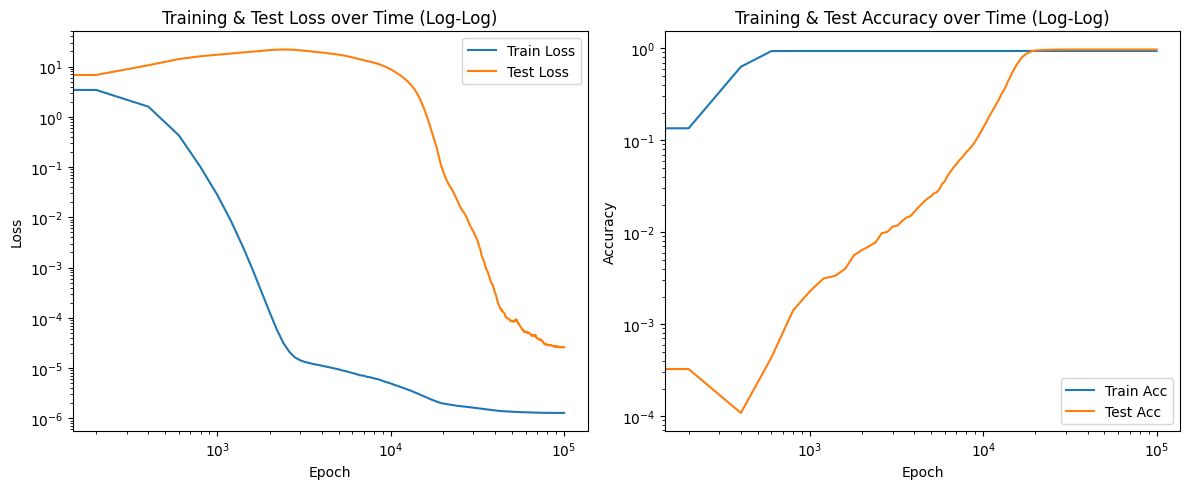

In [2]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.loglog(epochs_logged, train_loss_vals, label='Train Loss')
plt.loglog(epochs_logged, test_loss_vals, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Test Loss over Time (Log-Log)')
plt.legend()
plt.subplot(1, 2, 2)
plt.loglog(epochs_logged, train_acc_vals, label='Train Acc')
plt.loglog(epochs_logged, test_acc_vals, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Test Accuracy over Time (Log-Log)')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
device = next(model.parameters()).device
hidden_size = model.hidden_size


W_ih = model.W_ih.weight
b_ih = model.W_ih.bias
W_hh = model.W_hh.weight
b_hh = model.W_hh.bias


i_slice = slice(0, hidden_size)
f_slice = slice(hidden_size, 2*hidden_size)
g_slice = slice(2*hidden_size, 3*hidden_size)
o_slice = slice(3*hidden_size, 4*hidden_size)

@torch.no_grad()
def run_modified_eval(eval_fn):
    
    model.eval()
    correct = 0
    total = 0
    batch_size = 512
    for start in range(0, len(test_seq), batch_size):
        end = start + batch_size
        batch_seq = test_seq[start:end].to(device)
        batch_t = test_targets[start:end].to(device)
     
        h = torch.zeros(batch_seq.size(0), hidden_size, device=device)
        c = torch.zeros(batch_seq.size(0), hidden_size, device=device)
        h, c = eval_fn(batch_seq, h, c)

      
        intermediate = model.fc1(h)
        logits = model.fc2(intermediate)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch_t).sum().item()
        total += (end - start)
    return correct / total

def lstm_cell_step(x_t, h, c):
    
    gates = (x_t @ W_ih.T) + b_ih + (h @ W_hh.T) + b_hh
    i = torch.sigmoid(gates[:, i_slice])
    f = torch.sigmoid(gates[:, f_slice])
    g = torch.tanh(gates[:, g_slice])
    o = torch.sigmoid(gates[:, o_slice])
    c = f * c + i * g
    h = torch.relu(c)
    return h, c

@torch.no_grad()
def eval_force_i(batch_seq, h, c):
    
    for t in range(2):
        x_t_indices = batch_seq[:, t]
        x_onehot = torch.zeros(batch_seq.size(0), model.vocab_size, device=device)
        x_onehot.scatter_(1, x_t_indices.unsqueeze(1), 1)
        
        gates = (x_onehot @ W_ih.T) + b_ih + (h @ W_hh.T) + b_hh
        i = torch.ones(batch_seq.size(0), hidden_size, device=device)
        f = torch.sigmoid(gates[:, f_slice])
        g = torch.tanh(gates[:, g_slice])
        o = torch.sigmoid(gates[:, o_slice])
        
        c = f * c + i * g
        h = torch.relu(c)
    return h, c

acc_force_i = run_modified_eval(eval_force_i)


@torch.no_grad()
def eval_force_o(batch_seq, h, c):
   
    for t in range(2):
        x_t_indices = batch_seq[:, t]
        x_onehot = torch.zeros(batch_seq.size(0), model.vocab_size, device=device)
        x_onehot.scatter_(1, x_t_indices.unsqueeze(1), 1)

        gates = (x_onehot @ W_ih.T) + b_ih + (h @ W_hh.T) + b_hh
        i = torch.sigmoid(gates[:, i_slice])
        f = torch.sigmoid(gates[:, f_slice])
        g = torch.tanh(gates[:, g_slice])
        o = torch.ones(batch_seq.size(0), hidden_size, device=device)

        c = f * c + i * g
        h = torch.relu(c)
    return h, c

acc_force_o = run_modified_eval(eval_force_o)


@torch.no_grad()
def eval_no_tanh_g_all(batch_seq, h, c):
 
    for t in range(2):
        x_t_indices = batch_seq[:, t]
        x_onehot = torch.zeros(batch_seq.size(0), model.vocab_size, device=device)
        x_onehot.scatter_(1, x_t_indices.unsqueeze(1), 1)

        gates = (x_onehot @ W_ih.T) + b_ih + (h @ W_hh.T) + b_hh
        i = torch.sigmoid(gates[:, i_slice])
        f = torch.sigmoid(gates[:, f_slice])
        g = gates[:, g_slice]  
        o = torch.sigmoid(gates[:, o_slice])

        c = f * c + i * g
        h = torch.relu(c)
    return h, c

acc_no_tanh_g = run_modified_eval(eval_no_tanh_g_all)


@torch.no_grad()
def gather_second_step_f():
  
    f_values = []
    batch_size=512
    for start in range(0, len(test_seq), batch_size):
        end = start+batch_size
        batch_seq = test_seq[start:end].to(device)
        b = end - start
        h_ = torch.zeros(b, hidden_size, device=device)
        c_ = torch.zeros(b, hidden_size, device=device)

      
        x_t_indices = batch_seq[:,0]
        x_onehot = torch.zeros(b, model.vocab_size, device=device)
        x_onehot.scatter_(1, x_t_indices.unsqueeze(1),1)
        gates = (x_onehot @ W_ih.T) + b_ih + (h_ @ W_hh.T) + b_hh
        i = torch.sigmoid(gates[:, i_slice])
        f = torch.sigmoid(gates[:, f_slice])
        g = torch.tanh(gates[:, g_slice])
        c_ = f*c_ + i*g
        h_ = torch.relu(c_)

        
        x_t_indices = batch_seq[:,1]
        x_onehot = torch.zeros(b, model.vocab_size, device=device)
        x_onehot.scatter_(1, x_t_indices.unsqueeze(1),1)
        gates = (x_onehot @ W_ih.T) + b_ih + (h_ @ W_hh.T) + b_hh
        i = torch.sigmoid(gates[:, i_slice])
        f_2 = torch.sigmoid(gates[:, f_slice])
        g = torch.tanh(gates[:, g_slice])
        f_values.append(f_2.cpu())
    f_values = torch.cat(f_values, dim=0)
    return f_values.mean(dim=0).to(device)  

f_mean = gather_second_step_f()

@torch.no_grad()
def eval_forced_f_second(batch_seq, h, c):
    
    x_t_indices = batch_seq[:,0]
    x_onehot = torch.zeros(batch_seq.size(0), model.vocab_size, device=device)
    x_onehot.scatter_(1, x_t_indices.unsqueeze(1),1)
    gates = (x_onehot @ W_ih.T)+ b_ih +(h@W_hh.T)+b_hh
    i = torch.sigmoid(gates[:, i_slice])
    f = torch.sigmoid(gates[:, f_slice])
    g = torch.tanh(gates[:, g_slice])
    c = f*c + i*g
    h = torch.relu(c)

    
    x_t_indices = batch_seq[:,1]
    x_onehot = torch.zeros(batch_seq.size(0), model.vocab_size, device=device)
    x_onehot.scatter_(1, x_t_indices.unsqueeze(1),1)
    gates = (x_onehot @ W_ih.T)+b_ih+(h@W_hh.T)+b_hh
    i = torch.sigmoid(gates[:, i_slice])

    f = f_mean.unsqueeze(0).expand(batch_seq.size(0), -1)
    g = torch.tanh(gates[:, g_slice])
    c = f*c + i*g
    h = torch.relu(c)

    return h,c

acc_forced_f = run_modified_eval(eval_forced_f_second)


@torch.no_grad()
def eval_no_relu_first_step(batch_seq, h, c):
    # first step no relu on c
    x_t_indices = batch_seq[:,0]
    x_onehot = torch.zeros(batch_seq.size(0), model.vocab_size, device=device)
    x_onehot.scatter_(1, x_t_indices.unsqueeze(1),1)
    gates = (x_onehot@W_ih.T)+b_ih+(h@W_hh.T)+b_hh
    i = torch.sigmoid(gates[:, i_slice])
    f = torch.sigmoid(gates[:, f_slice])
    g = torch.tanh(gates[:, g_slice])
    c = f*c + i*g
    h = c # no relu here

 
    x_t_indices = batch_seq[:,1]
    x_onehot = torch.zeros(batch_seq.size(0), model.vocab_size, device=device)
    x_onehot.scatter_(1, x_t_indices.unsqueeze(1),1)
    gates = (x_onehot@W_ih.T)+b_ih+(h@W_hh.T)+b_hh
    i = torch.sigmoid(gates[:, i_slice])
    f = torch.sigmoid(gates[:, f_slice])
    g = torch.tanh(gates[:, g_slice])
    c = f*c + i*g
    h = torch.relu(c)

    return h,c

acc_no_relu_first = run_modified_eval(eval_no_relu_first_step)

# Print accuracies
print("Accuracy forcing i=1:", acc_force_i)
print("Accuracy forcing o=1:", acc_force_o)
print("Accuracy no tanh in g (both steps):", acc_no_tanh_g)
print("Accuracy forced f at second step:", acc_forced_f)
print("Accuracy no relu at first step:", acc_no_relu_first)


Accuracy forcing i=1: 0.9698350694444444
Accuracy forcing o=1: 0.9699435763888888
Accuracy no tanh in g (both steps): 0.9694010416666666
Accuracy forced f at second step: 0.9699435763888888
Accuracy no relu at first step: 0.9699435763888888


In [4]:
device = next(model.parameters()).device
hidden_size = model.hidden_size
W_ih = model.W_ih.weight      
b_ih = model.W_ih.bias        
W_hh = model.W_hh.weight      
b_hh = model.W_hh.bias       

W1 = model.fc1.weight         
W2 = model.fc2.weight        


g_start = 2*hidden_size
g_end = 3*hidden_size

W_g_ih = W_ih[g_start:g_end, :]  
b_g_ih = b_ih[g_start:g_end]      
W_g_hh = W_hh[g_start:g_end, :]  
b_g_hh = b_hh[g_start:g_end]   
b_g = b_g_ih + b_g_hh             
F = torch.ones(hidden_size, device=device)  

W_g_ih_np = W_g_ih.detach().cpu().numpy()    
W_g_hh_np = W_g_hh.detach().cpu().numpy()    
b_g_np = b_g.detach().cpu().numpy()        
F_np = F.detach().cpu().numpy()              

W1_np = W1.detach().cpu().numpy()            
W2_np = W2.detach().cpu().numpy()            



N = 113  
u_table_new = np.zeros((N, hidden_size), dtype=np.float32)
v_table_new = np.zeros((N, hidden_size), dtype=np.float32)

for a in range(N):
    W_g_ih_Ea = W_g_ih_np[:, a]  
    c_1 = W_g_ih_Ea + b_g_np   
    h_1 = np.maximum(c_1, 0)     
    u_a = F_np * c_1 + W_g_hh_np @ h_1 + b_g_np
    u_table_new[a] = u_a

for b in range(N):
    W_g_ih_Eb = W_g_ih_np[:, b]
    v_table_new[b] = W_g_ih_Eb

@torch.no_grad()
def evaluate_simplified_model_double_linear(u_table, v_table, W1, W2, test_seq, test_targets, batch_size=512):
    correct = 0
    total = 0
    # Convert back to torch
    u_torch = torch.from_numpy(u_table).to(device)
    v_torch = torch.from_numpy(v_table).to(device)
    W1_torch = torch.from_numpy(W1).to(device)
    W2_torch = torch.from_numpy(W2).to(device)
    W1_torch = W1_torch.float()
    W2_torch = W2_torch.float()

    for start in range(0, len(test_seq), batch_size):
        end = start+batch_size
        batch_seq = test_seq[start:end]
        batch_t = test_targets[start:end]

        a_indices = batch_seq[:, 0]
        b_indices = batch_seq[:, 1]

        u_vals = u_torch[a_indices]  
        v_vals = v_torch[b_indices]  

        c2 = u_vals + v_vals
        h2 = torch.relu(c2)  

       
        inner = W1_torch @ h2.T  
        
        logits = (W2_torch @ inner).T 

        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch_t).sum().item()
        total += (end - start)
    return correct / total

accuracy_simplified_new = evaluate_simplified_model_double_linear(u_table_new, v_table_new, W1_np, W2_np, test_seq, test_targets)
print("Accuracy of the new simplified model (no relu between W1 and W2):", accuracy_simplified_new)


Accuracy of the new simplified model (no relu between W1 and W2): 0.8894314236111112
